# Coding Permutation Importance from Scratch

In this notebook, we'll recreate SKlearn's permutation importance from scratch.

If you already know about it, then you can skip to the code, otherwise here's why it's important.

Permutation importance is a model agnostice (fancy way to say it works with any model) explainability technique used to obtain the importance of features based on their impact on a trained ML model’s prediction.

The permutation feature importance is defined as the decrease in a model score when a single feature value is randomly shuffled. It breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

It's mainly used for tabular datasets.

The way it works is that it takes an already trained ML model and a the test set. It computes the reference score of the model on the test data and then shuffles each feature one by one. For each feature, it computes the difference between the reference score and the score obtained after permuting that feature (hence the name permutation importance). The larger this difference, the more important that feature is for the model.

In [1]:
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

We'll load the popular diabetes dataset. Using this dataset, because it's a nice clean dataset. No nulls and only numbers. No pipeline required.

In [2]:
X, y = datasets.load_diabetes(return_X_y=True, as_frame=True)

In case you've never seen the diabetes dataset, here's a preview.

In [3]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


We'll split into train and test. We'll use the test set to calculate the permutations importance. Also, not setting a split percentage, defaults to 25% for the test set.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Because we don't care about performance, we'll train a vanilla random forest. Using random forest also allows us to not have to standardize/normalize the data.

In [5]:
rf = RandomForestRegressor()

In [6]:
rf.fit(X_train, y_train)

RandomForestRegressor()

We'll get the R2 score for our trained model. It's the reference we'll use to compare our shuffled feature results.

In [7]:
rf.score(X_test, y_test)

0.5064246498217824

Below are the 2 functions which break down what we're trying to accomplish.

The get_feat_shuffled_score is used inside the my_permutation_importance.

The get_feat_shuffled_score function shuffles the values of a feature in a dataset and returns the score of the model on the shuffled dataset.

Here is what each argument of the function does:

model: The machine learning model that you want to evaluate.<br>
X: The input features of your dataset.<br>
y: The target variable of your dataset.<br>
feat: The name of the feature that you want to shuffle.<br>
random_state: The random seed used for shuffling.<br>

The function shuffles the values of the feature specified by feat in the input features X. It then returns the score of the model on the shuffled dataset.

You're going to have to forgive the \** , because I don't know how to use a string inside Pandas assign without the double-stars.

In [8]:
def get_feat_shuffled_score(model, X, y, feat, random_state):
    return model.score(
                X.reset_index(drop=True).assign(
                    **{feat : (
                        X[feat]
                        .sample(frac=1, random_state=random_state)
                        .reset_index(drop=True)
                    )}
                ),
                y.reset_index(drop=True)
            )

The my_permutation_importance function gets the original non-shuffled score of the model and then shuffles the data 1 feature at a time and gets the difference of the model score on the randomly shuffled dataset.

Here is how the function works:

1. It first calculates the original score of the model on the input data.
2. For each feature in X, it shuffles that feature n_repeats times and calculates the score of the model on each shuffled dataset.
3. It then calculates the difference between the original score and each shuffled score for each feature.
4. It stores these differences in an array called feat_level_importances.
5. It then appends feat_level_importances to permutation_dict[‘importances’] as a new row.
6. It also appends feat_level_importances.mean() to permutation_dict[‘importances_mean’] and feat_level_importances.std() to permutation_dict[‘importances_std’].

The function takes in five parameters:

model: the estimator for which feature importance needs to be calculated.<br>
X: the input data.<br>
y: the target variable.<br>
n_repeats: the number of times a feature is randomly shuffled.<br>
random_state: the random seed

The function returns a dictionary containing three keys:

importances_mean: an array containing the mean importance score for each feature.<br>
importances_std: an array containing the standard deviation of importance scores for each feature.<br>
importances: a 2D array containing the importance scores for each feature across all repeats.

In [9]:
def my_permutation_importance(model, X, y, n_repeats, random_state):
    permutation_dict = {
        'importances_mean': np.array([]),
        'importances_std': np.array([]),
        'importances': np.empty([0, n_repeats])
    }
    orig_score = model.score(X, y)

    for feat in X.columns:
        feat_level_importances = np.array([])
        
        for i in range(n_repeats):
            new_score = get_feat_shuffled_score(model, X, y, feat, random_state+i)   
            score_difference = orig_score-new_score
            feat_level_importances = np.append(feat_level_importances, score_difference)
        
        permutation_dict['importances'] = np.vstack([permutation_dict['importances'], feat_level_importances.reshape(1,-1)])
        permutation_dict['importances_mean'] = np.append(permutation_dict['importances_mean'], feat_level_importances.mean())
        permutation_dict['importances_std'] = np.append(permutation_dict['importances_std'], feat_level_importances.std())
        
    return permutation_dict

The following block of code is the permutation importance we made from scratch.

In [10]:
my_result = my_permutation_importance(
    rf, X_test, y_test, n_repeats=50, random_state=42
)

This following block of code is the permutation importance from SKlearn

In [11]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=50, random_state=42
)

This plot_permutation_importance is just a fancy function to print fancy graphs. I stole it from SKlearn's site.

In [12]:
def plot_permutation_importance(perm_dict, X, title):
    sorted_importances_idx = perm_dict['importances_mean'].argsort()
    importances = pd.DataFrame(
        perm_dict['importances'][sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(title)
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel('Decrease in accuracy score')
    ax.figure.tight_layout()

And below we have 2 graphs.

SKlearn's permutation importance on top and mine on the bottom.

They're essentially the same. There's a bit of discrepency which is likely due to how the random state is handled between the 2 methods.

Other than that, you now know how permutation importance works from scratch.

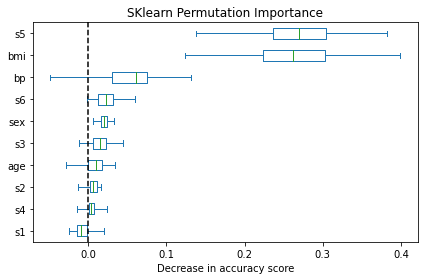

In [13]:
plot_permutation_importance(result, X_test, 'SKlearn Permutation Importance')

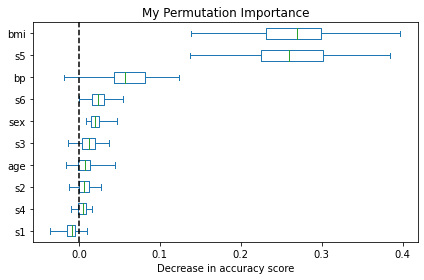

In [14]:
plot_permutation_importance(my_result, X_test, 'My Permutation Importance')